In [1]:
from __future__ import division, print_function
%matplotlib inline

# Feature detection

Feature detection is often the end result of image processing. We'll detect some basic features (edges, points, and circles) in this section, but there are a wealth of feature detectors that are available.

## Edge detection

Before we start, let's set the default colormap to grayscale and turn off pixel interpolation.

In [2]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'none'

We've already discussed edge filtering, using the Sobel filter, in the last section.

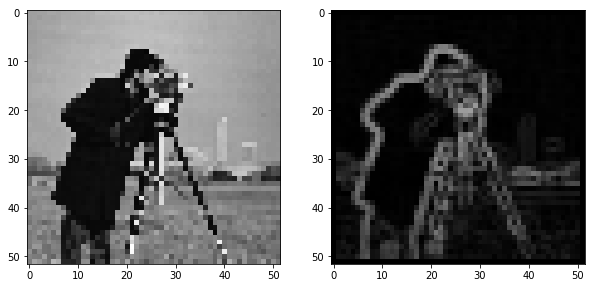

In [3]:
import skdemo
from skimage import data
# Rename module so we don't shadow the builtin function
import skimage.filters as filters

image = data.camera()
pixelated = image[::10, ::10]
gradient = filters.sobel(pixelated)
skdemo.imshow_all(pixelated, gradient)

With the Sobel filter, however, we get back a grayscale image, which essentially tells us the likelihood that a pixel is on the edge of an object.

We can apply a bit more logic to *detect* an edge; i.e. we can use that filtered image to make a *decision* whether or not a pixel is on an edge. The simplest way to do that is with thresholding:

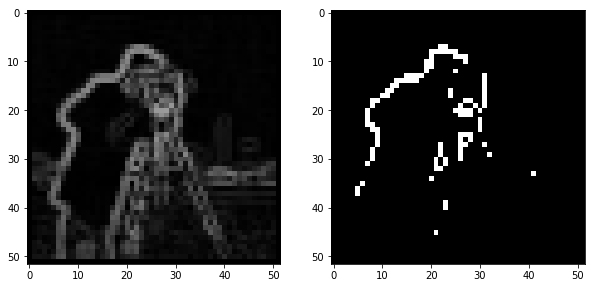

In [4]:
skdemo.imshow_all(gradient, gradient > 0.4)

That approach doesn't do a great job. It's noisy and produces thick edges. Furthermore, it doesn't use our *knowledge* of how edges work: They should be thin and tend to be connected along the direction of the edge.

### Canny edge detector

The Canny edge detector combines the Sobel filter with a few other steps to give a binary edge image. The steps are as follows:
* Gaussian filter
* Sobel filter
* Non-maximal suppression
* Hysteresis thresholding

Let's go through these steps one at a time.

### Step 1: Gaussian filter

As discussed earlier, gradients tend to enhance noise. To combat this effect, we first smooth the image using a gradient filter:

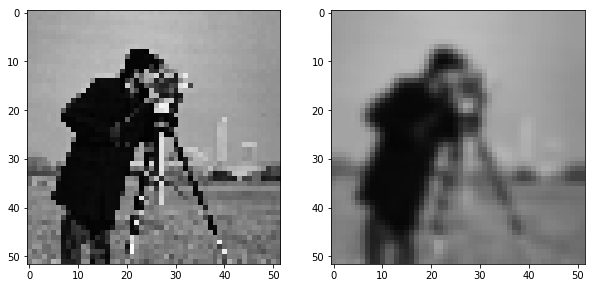

In [5]:
from skimage import img_as_float

sigma = 1  # Standard-deviation of Gaussian; larger smooths more.
pixelated_float = img_as_float(pixelated)
pixelated_float = pixelated
smooth = filters.gaussian(pixelated_float, sigma)
skdemo.imshow_all(pixelated_float, smooth)

### Step 2: Sobel filter

Next, we apply our edge filter:

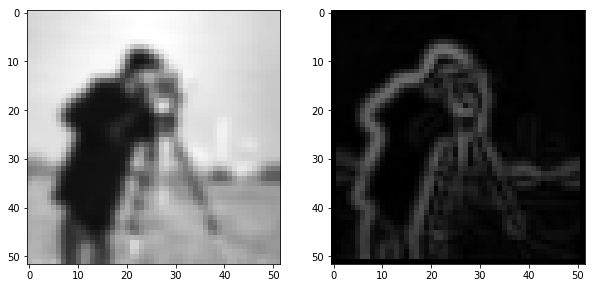

In [6]:
gradient_magnitude = filters.sobel(smooth)
skdemo.imshow_all(smooth, gradient_magnitude)

### Step 3: Non-maximal suppression

Goal: Suppress gradients that aren't on an edge

Ideally, an edge is thin: In some sense, an edge is infinitely thin, but images are discrete so we want edges to be a single pixel wide. To accomplish this, we thin the image using "non-maximal suppression". This takes the edge-filtered image and thins the response *across* the edge direction; i.e. in the direction of the maximum gradient:

/home/guimilan/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:55: UserWarning: The default of `clip_negative` in `skimage.util.dtype_limits` will change to `False` in version 0.15.
  warn('The default of `clip_negative` in `skimage.util.dtype_limits` '


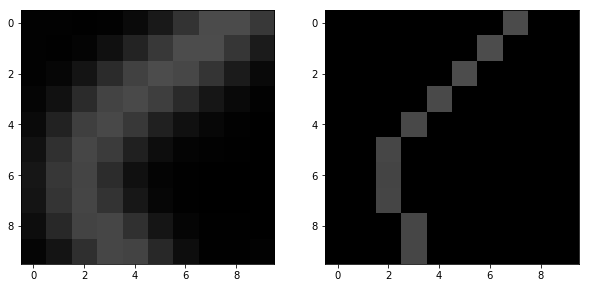

In [7]:
zoomed_grad = gradient_magnitude[15:25, 5:15]
maximal_mask = np.zeros_like(zoomed_grad)
# This mask is made up for demo purposes
maximal_mask[range(10), (7, 6, 5, 4, 3, 2, 2, 2, 3, 3)] = 1
grad_along_edge = maximal_mask * zoomed_grad
skdemo.imshow_all(zoomed_grad, grad_along_edge, limits='dtype')

Obviously, this is a faked version of non-maximal suppression: Pixels are *manually* masked here. The actual algorithm detects the direction of edges, and keeps a pixel only if it has a locally maximal gradient-magnitude in the direction *normal to the edge direction*. It doesn't mask pixels *along* the edge direction since an adjacent edge pixel will be of comparable magnitude.

The result of the filter is that an edge is only possible if there are no better edges near it.

### Step 4: Hysteresis thresholding

Goal: Prefer pixels that are connected to edges

The final step is the actual decision-making process. Here, we have two parameters: The low threshold and the high threshold. The high threshold sets the gradient value that you *know* is definitely an edge. The low threshold sets the gradient value that could be an edge, but only if it's connected to a pixel that we know is an edge.

These two thresholds are displayed below:

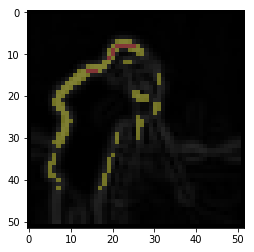

In [8]:
from skimage import color

low_threshold = 0.2
high_threshold = 0.3
label_image = np.zeros_like(pixelated)
# This uses `gradient_magnitude` which has NOT gone through non-maximal-suppression.
label_image[gradient_magnitude > low_threshold] = 1
label_image[gradient_magnitude > high_threshold] = 2
demo_image = color.label2rgb(label_image, gradient_magnitude,
                             bg_label=0, colors=('yellow', 'red'))
plt.imshow(demo_image)

The **red points** here are above `high_threshold` and are seed points for edges. The **yellow points** are edges if connected (possibly by other yellow points) to seed points; i.e. isolated groups of yellow points will not be detected as edges.

Note that the demo above is on the edge image *before* non-maximal suppression, but in reality, this would be done on the image *after* non-maximal suppression. There isn't currently an easy way to get at the intermediate result.

### The Canny edge detector

Now we're ready to look at the actual result:

In [9]:
from IPython.html import widgets
from skimage import data
import skimage.feature

image = data.coins()

def canny_demo(**kwargs):
    edges = skimage.feature.canny(image, **kwargs)
    plt.imshow(edges)
    plt.show()
# As written, the following doesn't actually interact with the
# `canny_demo` function. Figure out what you need to add.
widgets.interact(canny_demo, sigma=(0.5, 5.0, 0.5), low_threshold=[None, 0.1], high_threshold=[None, 0.3]);  # <-- add keyword arguments for `canny`

/home/guimilan/anaconda3/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


interactive(children=(FloatSlider(value=2.5, description='sigma', max=5.0, min=0.5, step=0.5), Dropdown(descri…

Play around with the demo above. Make sure to add any keyword arguments to `interact` that might be necessary. (Note that keyword arguments passed to `interact` are passed to `canny_demo` and forwarded to `filter.canny`. So you should be looking at the docstring for `filter.canny` or the discussion above to figure out what to add.)

Can you describe how the low threshold makes a decision about a potential edge, as compared to the high threshold?

## Aside: Feature detection in research

When taking image data for an experiment, the end goal is often to detect some sort of feature. Here are a few examples from some of my own research.

### Feature detection: case study

I got started with image processing when I needed to detect the position of a device I built to study swimming in viscous environments (low-Reynolds numbers):

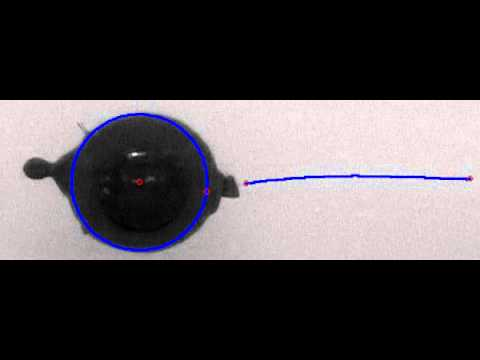

In [10]:
from IPython.display import Image, YouTubeVideo

YouTubeVideo('1Pjlj9Pymx8')

### Particle detection

For my post-doc, I ended up investigating the collection of fog from the environment and built the apparatus displayed below:

In [11]:
from IPython.display import Image, YouTubeVideo

#Image(filename='images/fog_tunnel.png')

The resulting experiments looked something like this:

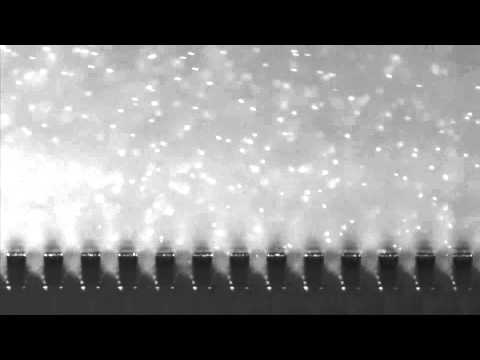

In [12]:
YouTubeVideo('14qlyhnyjT8')

The water droplets in the video can be detected using some of the features in `scikit-image`. In particular, `peak_local_max` from the `feature` package is useful here. (We'll play with this function in the Hough transform section.) There's a bit more work to get subpixel accuracy, but that function can get you most of the way there:

In [13]:
#Image(filename='images/particle_detection.png')

### Circle detection

If we look at the previous video over a longer period of time (time-lapsed), then we can see droplets accumulating on the surface:

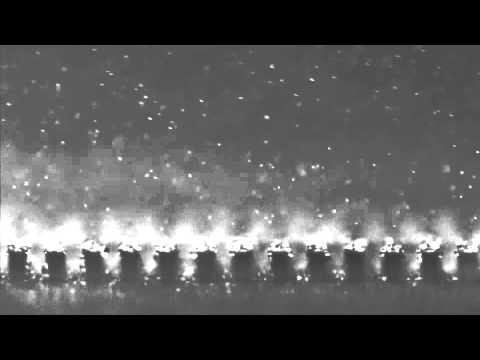

In [14]:
YouTubeVideo('_qeOggvx5Rc')

To allow easier measurement, the microscope objective was moved to a top-down view on the substrate in the video below:

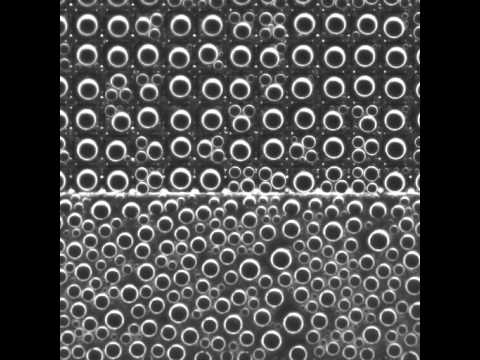

In [15]:
YouTubeVideo('8utP9Ju_rdc')

At the time, I was interested in figuring out how droplet sizes evolved. To accomplish that, we could open up each frame in some image-analysis software and manually measure each drop size. That becomes pretty tediuous, pretty quickly. Using feature-detection techniques, we can get a good result with significantly less effort.

In [16]:
#Image(filename='images/circle_detection.png')

In case you're wondering about the differences between the flat (lower) and textured (upper) surfaces pictured above, the circle measurements were used to describe the difference in growth, which is summarized below:

In [17]:
#Image(filename='images/power_law_growth_regimes.png')

## Hough transforms

Hough transforms are a general class of operations that make up a step in feature detection. Just like we saw with edge detection, Hough transforms produce a result that we can use to detect a feature. (The distinction between the "filter" that we used for edge detection and the "transform" that we use here is a bit arbitrary.)

### Circle detection

To explore the Hough transform, let's take the *circular* Hough transform as our example. Let's grab an image with some circles:

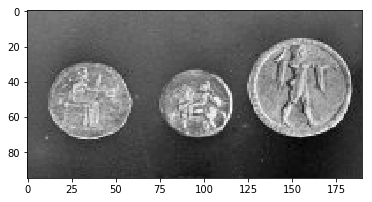

In [18]:
image = data.coins()[0:95, 180:370]
plt.imshow(image);

We can use the Canny edge filter to get a pretty good representation of these circles:

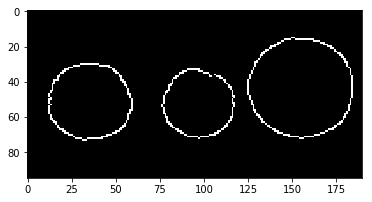

In [19]:
edges = skimage.feature.canny(image, sigma=3, low_threshold=10, high_threshold=60)
plt.imshow(edges);

While it looks like we've extracted circles, this doesn't give us much if what we want to do is *measure* these circles. For example, what are the size and position of the circles in the above image? The edge image doesn't really tell us much about that.

We'll use the Hough transform to extract circle positions and radii:

In [20]:
from skimage.transform import hough_circle
 
hough_radii = np.arange(15, 30, 2)
hough_response = hough_circle(edges, hough_radii)

Here, the circular Hough transform actually uses the edge image from before. We also have to define the radii that we want to search for in our image.

So... what's the actual result that we get back?

In [21]:
print(edges.shape)
print(hough_response.shape)

(95, 190)
(8, 95, 190)


We can see that the last two dimensions of the response are exactly the same as the original image, so the response is image-like. Then what does the first dimension correspond to?

As always, you can get a better feel for the result by plotting it:

In [22]:
# Use max value to intelligently rescale the data for plotting.
h_max = hough_response.max()

def hough_responses_demo(i):
    # Use `plt.title` to add a meaningful title for each index.
    plt.imshow(hough_response[i, :, :], vmax=h_max*0.5)
    plt.show()
widgets.interact(hough_responses_demo, i=(0, len(hough_response)-1));

interactive(children=(IntSlider(value=3, description='i', max=7), Output()), _dom_classes=('widget-interact',)…

Playing around with the slider should give you a pretty good feel for the result.

This Hough transform simply counts the pixels in a thin (as opposed to filled) circular mask. Since the input is an edge image, the response is strongest when the center of the circular mask lies at the center of a circle with the same radius.

---

## <span style="color:cornflowerblue">Exercise:</span>

Use the response from the Hough transform to **detect the position and radius of each coin**.

Center (152,43) Radius 27
Center (35,52) Radius 23
Center (38,51) Radius 21
Center (33,51) Radius 21
Center (98,52) Radius 19
Center (96,52) Radius 19


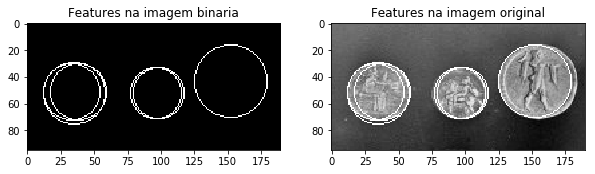

In [36]:
from skimage.feature import peak_local_max
from skimage.draw import circle_perimeter

peaks = peak_local_max(hough_response, threshold_rel=0.75)
#print(peaks[0:5])
blank = np.zeros(shape=edges.shape)

for peak in peaks:
    #print(peak[1:])
    x_c = peak[1]
    y_c = peak[2]
    #blank[x_c:x_c+5, y_c:y_c+5] = 1
    print('Center ({},{}) Radius {}'.format(y_c,x_c, hough_radii[peak[0]]))
    circle_coords = circle_perimeter(x_c, y_c, hough_radii[peak[0]])
    blank[circle_coords] = 1
    image[circle_coords] = 255

fig, axes = plt.subplots(1,2, figsize=(10,10))
axes[0].set_title('Features na imagem binaria')
axes[0].imshow(blank)
axes[1].set_title('Features na imagem original')
axes[1].imshow(image)

centers = []
likelihood = []
# Your code here

The same concept described in this section can be applied to line detection, ellipse detection, and various other features of interest.

---

## Further reading

### Interest point detection

We've only skimmed the surface of what might be classified as "feature detection". One major area that we haven't covered is called [interest point detection](http://en.wikipedia.org/wiki/Interest_point_detection). Here, we don't even need to know what we're looking for, we just identify small patches (centered on a pixel) that are "distinct". (The definition of "distinct" varies by algorithm; e.g., the Harris corner detector defines interest points as corners.) These distinct points can then be used to, e.g., compare with distinct points in other images.

One common use of interest point detection is for image registration, in which we align (i.e. "register") images based on interest points. Here's an example of the [CENSURE feature detector from the gallery](http://scikit-image.org/docs/dev/auto_examples/plot_censure.html):

In [24]:
#Image(filename='images/censure_example.png')

FileNotFoundError: [Errno 2] No such file or directory: 'images/censure_example.png'

* [Probabilistic Hough transform](http://scikit-image.org/docs/dev/auto_examples/plot_line_hough_transform.html)
* [Circular and elliptical Hough transforms](http://scikit-image.org/docs/dev/auto_examples/plot_circular_elliptical_hough_transform.html)
* [Template matching](http://scikit-image.org/docs/dev/auto_examples/plot_template.html)
* [Histogram of Oriented Gradients](http://scikit-image.org/docs/dev/auto_examples/plot_hog.html)
* [BRIEF](http://scikit-image.org/docs/dev/auto_examples/plot_brief.html), [CENSURE](http://scikit-image.org/docs/dev/auto_examples/plot_censure.html), and [ORB](http://scikit-image.org/docs/dev/auto_examples/plot_orb.html) feature detectors/descriptors
* [Robust matching using RANSAC](http://scikit-image.org/docs/dev/auto_examples/plot_matching.html)

---

<div style="height: 400px;"></div>

In [ ]:
%reload_ext load_style
%load_style ../themes/tutorial.css